## Using TensorBoard

In [0]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

In [0]:
# import os
# LOG_DIR = 'runs'
# os.makedirs(LOG_DIR, exist_ok=True)
# get_ipython().system_raw(
#     'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#     .format(LOG_DIR))

In [0]:
# get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
# ! curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [0]:
# from torch.utils.tensorboard import SummaryWriter
# # load data from loader
# images, labels = next(iter(train_dataloader))

# images = images.to('cuda')
# labels = labels.to('cuda')

# tb = SummaryWriter()
# tb.add_images("Image", images)
# tb.add_graph(net, images)
# for i in range(1, 20):
#     tb.add_scalar("Tag", 10/i, i)
    
# tb.close()

## Declaring variables:

In [0]:
from __future__ import print_function, division
from pathlib import Path
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from IPython.core.debugger import set_trace
import cv2
from PIL import Image
import random

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

path = Path('drive/My Drive/Colab/Ear_Project')
if not os.path.exists('./dataset_original/dataset'):
   os.chdir(path)

#reproducibility

random.seed(420)
torch.manual_seed(420)
torch.cuda.manual_seed(420)
np.random.seed(420)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
class AutoCanny():
  def __call__(self,sample):
    img, label = sample['image'], sample['label']
    img = np.asarray(img)
    img = cv2.bilateralFilter(img, 4, 70, 110)
    img = auto_canny(img)

    return {'image': img.astype(np.float32) ,'label': label}

class Padding():
  def __call__(self,sample):
    img, label = sample['image'], sample['label']
    w, h = img.size[:2]
    pad_width, pad_height = (max(0,h-w), max(0,w-h))

    if pad_width % 2 == 0:
      pad_right = pad_left = int(pad_width/2)
    else:
      pad_right = int(pad_width/2)
      pad_left = int(pad_width/2) + 1

    if pad_height % 2 == 0:
      pad_top = pad_bottom = int(pad_height/2)
    else:
      pad_top = int(pad_height/2)
      pad_bottom = int(pad_height/2) + 1

    img = transforms.functional.pad(img, padding=(pad_left, pad_top, pad_right, pad_bottom))
    

    return {'image': img, 'label': label}

class Resize():
  def __call__(self, sample):
    img, label = sample['image'], sample['label']
    img = transforms.functional.resize(img, 96)
    # set_trace()
    # img = np.asarray(img)
    # img = cv2.resize(img,(96,96),interpolation = cv2.INTER_AREA)
    return {'image': img, 'label': label}

class ToTensor(object):
  """Convert ndarrays in sample to Tensors."""

  def __call__(self, sample):
      img, label = (sample['image'], sample['label'])      
      # swap color axis because
      # numpy image: H x W x C
      # torch image: C X H X W
      img = img.reshape(96,96,1)
      img = img.transpose((2, 0, 1))
      return {'image': torch.from_numpy(img), 'label': torch.from_numpy(label)}

class Normalize():
  def __init__(self, mean, std, inplace=False):
    self.mean = mean
    self.std = std
    self.inplace = inplace

  def __call__(self, sample):
    img, label = sample['image'], sample['label']

    return transforms.functional.normalize(img, self.mean, self.std, self.inplace), label


def auto_canny(image, sigma=0.6):
	v = np.median(image)
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)

	return edged
  #edged.astype(np.float32)


def show_batch(batch):
  images_batch, label = batch
  grid = utils.make_grid(images_batch)
  for img in images_batch:
    print (img.shape)
    # print(f'Min pixel value: {min(img)},\nMax pixel value: {max(img)}')
  plt.imshow(grid.numpy().transpose(1,2,0))



In [0]:
class CNNNet(nn.Module):
  def __init__(self):
    super(CNNNet, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(1, 16, 3, padding=1),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
      nn.Conv2d(16, 16, kernel_size=3, padding=1),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.classifier = nn.Sequential(
      nn.Linear(16*24*24, 1000),
      nn.Linear(1000, 100),
      nn.Linear(100, 8),
    )
  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

net = CNNNet().cuda()

In [0]:
def standard(img):
  return (img - np.mean(img)) / np.std(img)

class EarDataset(Dataset):

  def __init__(self, pkl_file, root_dir, transform=None):
    self.dataset = pd.read_pickle(pkl_file)
    self.root_dir = root_dir
    self.transform = transform
      
  def __len__(self):
    return len(self.dataset)


  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    img_name = os.path.join(self.root_dir, self.dataset.iloc[idx, 0])
    image = Image.open(img_name)
    image = image.convert('L')
    label = self.dataset.iloc[idx,1].astype(np.float32)
    sample = {'image': image, 'label': label}


    if self.transform:
      sample = self.transform(sample)
    return sample


class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.subset[index]
        if self.transform:
            img, label = self.transform((img, label))
        return img, label

    def __len__(self):
        return len(self.subset)

In [0]:
transform = transforms.Compose([Padding(),
                                Resize(),
                                AutoCanny(),
                                ToTensor(),
                                Normalize([0],[255]),
                                ])

pkl_file = 'dataset109.pkl'

root_dir_original = 'dataset_original/dataset'

init_dataset = EarDataset(pkl_file=pkl_file, root_dir=root_dir_original, transform=transform)

total_len = len(init_dataset)

lengths = [int(0.8*total_len), int(0.1*total_len), int(0.1*total_len)]

train_subset, valid_subset, test_subset = random_split(init_dataset, lengths)

train_dataset = DatasetFromSubset(train_subset, transform=None)
valid_dataset = DatasetFromSubset(valid_subset, transform=None)
test_dataset = DatasetFromSubset(test_subset, transform=None)

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)
test_dataloader = DataLoader(test_dataset, batch_size=2)

In [11]:
lengths

[88, 11, 11]

torch.Size([1, 96, 96])
torch.Size([1, 96, 96])


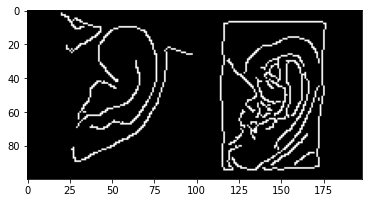

In [12]:
batch = next(iter(train_dataloader))
show_batch(batch)

In [0]:
# iterator = iter(valid_dataloader)

# for a in iterator:
#   show_batch(a)

In [0]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()


def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
  model.apply(weight_reset)
  for epoch in range(epochs):
    training_loss = 0.0
    valid_loss = 0.0
    model.train()
    for batch in train_loader:
      optimizer.zero_grad()
      inputs, target = batch
      inputs = inputs.to(device)
      target = target.to(device)
      output = model(inputs)
      loss = loss_fn(output, target)
      loss.backward()
      optimizer.step()
      training_loss += loss.item()
      train_error = torch.dist(target, output)
    training_loss /= len(train_loader)

    model.eval()
    num_correct = 0
    num_examples = 0
    for batch in val_loader:
      inputs, targets = batch
      inputs = inputs.to(device)
      output = model(inputs)
      targets = targets.to(device)
      loss = loss_fn(output,targets)
      valid_loss += loss.item()
      val_error = torch.dist(targets, output)
    valid_loss /= len(val_loader)

    print(f'Epoch: {epoch}, Training Loss: {training_loss}, Validation Loss: {valid_loss}, Train Error = {train_error}, Validation Error = {val_error}')


In [15]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.00005)

train(model=net, optimizer=optimizer, loss_fn=criterion,
      train_loader=train_dataloader, val_loader=valid_dataloader,
      epochs=50, device="cuda")


Epoch: 0, Training Loss: 1.5740704783661799, Validation Loss: 0.1063351600120465, Train Error = 3.0305967330932617, Validation Error = 0.6139079332351685
Epoch: 1, Training Loss: 0.16940739750862122, Validation Loss: 0.16081380285322666, Train Error = 1.4103578329086304, Validation Error = 1.1104235649108887
Epoch: 2, Training Loss: 0.13007101594385775, Validation Loss: 0.17005995102226734, Train Error = 1.52548348903656, Validation Error = 1.1438385248184204
Epoch: 3, Training Loss: 0.10605788412927226, Validation Loss: 0.1271920328338941, Train Error = 1.0806171894073486, Validation Error = 0.9755902886390686
Epoch: 4, Training Loss: 0.08588219925083897, Validation Loss: 0.12103513938685258, Train Error = 0.732671320438385, Validation Error = 0.9661291241645813
Epoch: 5, Training Loss: 0.07100361953912811, Validation Loss: 0.12815800433357558, Train Error = 0.8563170433044434, Validation Error = 1.0228245258331299
Epoch: 6, Training Loss: 0.05437164298597385, Validation Loss: 0.17481

Epoch: 49, Training Loss: 0.006912451507311992, Validation Loss: 0.19517305245002112, Train Error = 0.3576761782169342, Validation Error = 1.1172915697097778


In [0]:
net.eval()
prediction = [net(batch[0].to('cuda')) for batch in test_dataloader]

In [37]:
for item in test_subset:
  print (item)

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), tensor([1.6100, 0.5800, 1.8700, 1.6300, 4.9300, 3.0500, 0.2200, 1.3000]))
(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), tensor([1.8500, 0.9800, 1.4700, 2.0700, 6.5100, 3.2800, 0.5600, 1.6000]))
(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), tensor([1.6200, 0.6400, 1.7000, 1.3900, 5.4900, 3.2500, 0.44

In [0]:
ground_truth = [batch[1].to('cuda') for batch in test_dataloader]




In [35]:
ground_truth = []

for batch in test_dataloader:
  for sample in batch:
    print(sample[1])

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([1.8500, 0.9800, 1.4700, 2.0700, 6.5100, 3.2800, 0.5600, 1.6000])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([1.7000, 0.7300, 1.6800, 1.9900, 6.5400, 3.2800, 0.4600, 1.6000])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([1.9237, 0.7887, 1.2437, 2.0105, 6.5534, 3.0588, 0.4535, 0.94

IndexError: ignored

In [0]:
net.eval()
prediction = [net(batch[0].to('cuda')) for batch in test_dataloader]

In [0]:
for gt, pred in zip(ground_truth, prediction):
  print (gt.)

In [11]:
prediction

[tensor([[1.8650, 0.8665, 1.4696, 1.5128, 6.2603, 3.5399, 0.4205, 1.2577],
         [2.0282, 0.9830, 1.6107, 1.8633, 6.6124, 3.8285, 0.3593, 1.3458]],
        device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[1.7313, 0.7127, 1.8696, 1.6309, 6.2710, 3.4318, 0.4130, 1.2384],
         [1.8903, 0.7777, 1.5078, 1.9298, 6.3369, 3.1768, 0.4827, 1.2926]],
        device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[1.9316, 0.5682, 1.4338, 1.4271, 5.9675, 2.9568, 0.5062, 1.2820],
         [1.9289, 0.9439, 1.5896, 1.5873, 6.6288, 3.1030, 0.2539, 1.0541]],
        device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[1.6576, 0.8643, 1.4338, 2.0365, 6.8740, 3.8790, 0.4397, 1.0781],
         [1.5161, 0.7592, 1.7941, 1.6911, 6.0376, 2.9039, 0.5787, 1.1258]],
        device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[1.7618, 0.8251, 1.4399, 1.6418, 6.1128, 3.0942, 0.5507, 1.3240],
         [2.0479, 0.8438, 1.8340, 1.5479, 6.2010, 3.1379, 0.5494, 1.4187]],
        device='cuda:0', grad_fn=<AddmmBa

In [0]:
# path = 'testset/0051_left.jpg'
# target = torch.tensor([1.7321, 0.82316, 1.7177, 1.3736, 5.94, 2.8194, 0.57672, 1.0697]).to('cuda')
# image = Image.open(path)
# sample_pred = {'image': image, 'label': np.random.randn(8)}
# transformed_sample = transform(sample_pred)
# print_img = transformed_sample[0]
# img = transformed_sample[0].unsqueeze(0).to('cuda')
# print(torch.max(img))
# prediction = net(img)
# error = torch.dist(target, prediction)
# print(f'prediction: {prediction}.\nGround truth: {target}.')
# print(error)

In [0]:
error = [torch.dist(ground_truth, prediction)]
erro = abs(target-prediction)
erro

In [0]:
erro.sum()


Previsão: 1.8504, 0.4400, 1.5174, 1.2913, 6.1952, 2.9311, 0.4214, 1.0045

Valor real: 1.7321	0.82316	1.7177	1.3736	5.94	2.8194	0.57672	1.0697

## Treinando vários modelos

In [0]:
batch1 = CNNNet().cuda()
optimizer1 = optim.Adam(batch1.parameters(), lr=0.00005)

train_dataloader1 = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader1 = DataLoader(test_dataset, batch_size=1)

train(model=batch1, optimizer=optimizer1, loss_fn=criterion,
      train_loader=train_dataloader1, val_loader=val_dataloader1,
      epochs=50, device="cuda")

In [0]:
batch2 = CNNNet().cuda()
optimizer2 = optim.Adam(batch2.parameters(), lr=0.00005)

train_dataloader2 = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader2 = DataLoader(test_dataset, batch_size=2)

train(model=batch2, optimizer=optimizer2, loss_fn=criterion,
      train_loader=train_dataloader2, val_loader=val_dataloader2,
      epochs=50, device="cuda")

In [0]:
batch4 = CNNNet().cuda()
optimizer4 = optim.Adam(batch4.parameters(), lr=0.00005)

train_dataloader4 = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader4 = DataLoader(test_dataset, batch_size=4)

train(model=batch4, optimizer=optimizer4, loss_fn=criterion,
      train_loader=train_dataloader4, val_loader=val_dataloader4,
      epochs=50, device="cuda")

In [0]:
batch8 = CNNNet().cuda()
optimizer8 = optim.Adam(batch8.parameters(), lr=0.00005)

train_dataloader8 = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader8 = DataLoader(test_dataset, batch_size=8)

train(model=batch8, optimizer=optimizer8, loss_fn=criterion,
      train_loader=train_dataloader8, val_loader=val_dataloader8,
      epochs=50, device="cuda")

In [0]:
batch16 = CNNNet().cuda()
optimizer16 = optim.Adam(batch16.parameters(), lr=0.00005)

train_dataloader16 = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader16 = DataLoader(test_dataset, batch_size=16)

train(model=batch16, optimizer=optimizer16, loss_fn=criterion,
      train_loader=train_dataloader16, val_loader=val_dataloader16,
      epochs=50, device="cuda")

In [0]:
batch32 = CNNNet().cuda()
optimizer32 = optim.Adam(batch32.parameters(), lr=0.00005)

train_dataloader32 = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader32 = DataLoader(test_dataset, batch_size=32)

train(model=batch32, optimizer=optimizer32, loss_fn=criterion,
      train_loader=train_dataloader32, val_loader=val_dataloader32,
      epochs=200, device="cuda")

In [0]:
prediction1 = batch1(img)
prediction2 = batch2(img)
prediction4 = batch4(img)
prediction8 = batch8(img)
prediction16 = batch16(img)
prediction32 = batch32(img)

erro1 = abs(target-prediction1)
erro2 = abs(target-prediction2)
erro4 = abs(target-prediction4)
erro8 = abs(target-prediction8)
erro16 = abs(target-prediction16)
erro32 = abs(target-prediction32)

print(f'Vetor de erros:\n1: {erro1}.\n2: {erro2}.\n4: {erro4}.\n8: {erro8}.\n16: {erro16}.\n32: {erro32}.')
print(f'Valores absolutos:\n1: {erro1.sum()}.\n2: {erro2.sum()}.\n4: {erro4.sum()}.\n8: {erro8.sum()}.\n16: {erro16.sum()}.\n32: {erro32.sum()}.')

In [0]:
!pip install onnx
!pip install onnxruntime

In [0]:
import io
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

batch32 = CNNNet().cuda()

batch32.eval()

x = torch.randn(32, 1, 96, 96, requires_grad=True).to('cuda')
torch_out = batch32(x)

# torch.onnx.export(
#     batch32,
#     x,
#     'model.onnx',
#     export_params=True,
# )

In [0]:
import onnx

onnx_model = onnx.load("model.onnx")
onnx.checker.check_model(onnx_model)

In [0]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("model.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")